In [29]:
import pandas as pd
import numpy as np
import h5torch
import py2bit
from tqdm import tqdm
from tqdm import trange

In [30]:
# Open the H5torch file in read mode
file_path = "/data/home/natant/Negatives/testing_ground/20250402_test.h5t"
f =  h5torch.File(file_path, "r")

In [31]:
f["0/prot_names"][:]

array([b'ATAC_peak', b'CTCF', b'YY1_(SC-281)', b'CREB1_(SC-240)', b'Max',
       b'TCF12', b'FOSL2', b'ELF1_(SC-631)', b'BHLHE40', b'ATF3',
       b'USF-1', b'ETS1', b'SIX5', b'ZBTB33', b'FOXA1_(SC-101058)'],
      dtype='|S17')

In [32]:
no_ATAC = f["central"][1:,:]

In [33]:
mask_all_zeros = (no_ATAC == 0).all(axis=0)
mask_all_zeros.sum()
#! these positions are in the central because of the ATAC signal not because of the TFs 
#! so they should not be taken into account for training!

np.int64(19738)

In [34]:
# Exclude columns where mask_all_zeros is True
filtered_no_ATAC = no_ATAC[:, ~mask_all_zeros]


In [35]:
not_all_zeros_indices = np.where(~mask_all_zeros)[0]


In [36]:
mapping = {"A": 0, "T": 1, "C": 2, "G": 3, "N": 4}
rev_mapping = {v : k for k, v in mapping.items()}
genome = {k : f["unstructured"][k] for k in list(f["unstructured"]) if k.startswith("chr")}

def get_sequence(indices, rev_map=True):
    """
    Get the sequence for a given index from the H5torch file.
    """
    seqs = []
    for j in tqdm(indices):
        chr = f["1/peak_ix_to_chr"][:][j].astype(str)
        pos = f["1/peak_ix_to_pos"][:][j]
        seq = genome[chr][pos-50:pos+51]
        if rev_map:
            seq = "".join([rev_mapping[bp] for bp in seq])
        seqs.append(seq)
    seqs = np.array(seqs)
    return seqs

In [37]:
from collections import Counter
DINUC_LIST = [
    "AA","AC","AG","AT",
    "CA","CC","CG","CT",
    "GA","GC","GG","GT",
    "TA","TC","TG","TT",
]

# Map each dinucleotide to an index 0..15 for quick lookup:
DINUC_IDX = {dinuc: i for i, dinuc in enumerate(DINUC_LIST)}

def dinuc_freq_vector(seq: str) -> np.ndarray:
    """
    Given a 101‐bp string `seq`, compute a length‐16 vector of dinucleotide frequencies.
    We slide a window of length 2 along positions 0→1, 1→2, …, 99→100 (i.e. 100 windows total).
    Returns a numpy array of shape (16,), where each entry = (count of that dinuc) / 100.
    """
    seq = seq.upper()
    cnt = np.zeros(16, dtype=float)
    total_windows = len(seq) - 1  # should be 100 for a 101 bp input

    # Count dinucleotides
    for i in range(total_windows):
        di = seq[i:i+2]
        if di in DINUC_IDX:
            cnt[DINUC_IDX[di]] += 1
        else:
            # If there are ambiguous bases (e.g. 'N'), you could either skip or distribute arbitrarily.
            # Here, we simply skip any window containing non‐ACGT.
            pass

    # Convert counts → frequencies (divide by total_windows)
    if total_windows > 0:
        cnt /= float(total_windows)
    return cnt

## Precalculate the dinucl freq matrix

In [38]:
# For demonstration, let's use a subset (e.g., first 100) of indices for efficiency
indices = not_all_zeros_indices  # or negatives[:100] or any other indices

# Get sequences for the indices
sequences = get_sequence(indices, rev_map=True)

# Calculate dinucleotide frequency vectors for each sequence
dinuc_vectors = np.array([dinuc_freq_vector(seq) for seq in sequences])

# Create a DataFrame: rows = indices, columns = dinucleotide names
df_dinuc = pd.DataFrame(dinuc_vectors, index=indices, columns=DINUC_LIST)
df_dinuc

100%|██████████| 28537/28537 [00:15<00:00, 1871.97it/s]


,AA,AC,AG,AT,CA,CC,CG,CT,GA,GC,GG,GT,TA,TC,TG,TT
7,0.04,0.03,0.12,0.02,0.09,0.06,0.03,0.07,0.08,0.10,0.11,0.06,0.00,0.06,0.09,0.04
8,0.04,0.03,0.12,0.02,0.09,0.06,0.03,0.07,0.08,0.10,0.11,0.06,0.00,0.06,0.09,0.04
9,0.03,0.04,0.10,0.01,0.09,0.06,0.05,0.08,0.04,0.11,0.15,0.06,0.02,0.07,0.06,0.03
10,0.03,0.04,0.11,0.02,0.10,0.06,0.05,0.07,0.05,0.12,0.15,0.05,0.02,0.05,0.06,0.02
12,0.03,0.04,0.06,0.03,0.04,0.05,0.09,0.09,0.06,0.14,0.15,0.04,0.02,0.04,0.10,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48270,0.03,0.04,0.09,0.01,0.06,0.10,0.08,0.08,0.05,0.14,0.14,0.04,0.02,0.04,0.07,0.01
48271,0.02,0.03,0.08,0.02,0.07,0.12,0.11,0.06,0.05,0.13,0.09,0.06,0.01,0.08,0.05,0.02
48272,0.08,0.06,0.09,0.08,0.10,0.07,0.01,0.06,0.09,0.05,0.05,0.02,0.04,0.06,0.06,0.08
48273,0.08,0.06,0.08,0.09,0.09,0.06,0.02,0.06,0.09,0.05,0.03,0.03,0.05,0.06,0.06,0.09


## Match positives to negatives

In [39]:
 #! GET POSITIVES AND NEGATIVES INDICES
# Specify the TF index (row index in no_ATAC)
tf_index = 0  # change this to the desired TF index

# Get the row for the specific TF from the original no_ATAC matrix
tf_row = no_ATAC[tf_index, :]

# Positives: indices where TF is present (value == 1)
positives = np.where(tf_row == 1)[0]

# Negatives: indices where TF is absent (value == 0) and not in mask_all_zeros
negatives = np.where((tf_row == 0) & (~mask_all_zeros))[0]

positives, negatives

(array([    8,     9,    23, ..., 48265, 48266, 48274], shape=(5506,)),
 array([   12,    13,    14, ..., 48271, 48272, 48273], shape=(17849,)))

In [40]:
df_dinuc_pos = df_dinuc.loc[positives]
df_dinuc_pos

,AA,AC,AG,AT,CA,CC,CG,CT,GA,GC,GG,GT,TA,TC,TG,TT
8,0.04,0.03,0.12,0.02,0.09,0.06,0.03,0.07,0.08,0.10,0.11,0.06,0.00,0.06,0.09,0.04
9,0.03,0.04,0.10,0.01,0.09,0.06,0.05,0.08,0.04,0.11,0.15,0.06,0.02,0.07,0.06,0.03
23,0.00,0.03,0.05,0.00,0.03,0.14,0.13,0.09,0.04,0.18,0.17,0.02,0.00,0.04,0.07,0.01
31,0.04,0.05,0.06,0.00,0.10,0.17,0.16,0.05,0.01,0.22,0.08,0.00,0.00,0.05,0.00,0.01
42,0.08,0.05,0.10,0.03,0.06,0.05,0.08,0.05,0.09,0.11,0.13,0.03,0.03,0.03,0.06,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48259,0.03,0.04,0.08,0.02,0.04,0.08,0.05,0.09,0.10,0.07,0.15,0.05,0.00,0.06,0.10,0.04
48264,0.05,0.02,0.10,0.05,0.11,0.03,0.00,0.04,0.02,0.10,0.06,0.11,0.04,0.02,0.13,0.12
48265,0.09,0.05,0.12,0.05,0.10,0.09,0.00,0.04,0.06,0.09,0.07,0.05,0.05,0.01,0.08,0.05
48266,0.16,0.03,0.11,0.03,0.11,0.10,0.00,0.04,0.04,0.05,0.04,0.08,0.03,0.06,0.06,0.06


In [41]:
pos_vecs = df_dinuc.loc[positives]    # shape = (n_pos, 16)
neg_vecs = df_dinuc.loc[negatives]    # shape = (n_neg, 16)

# If there are more negatives than positives (as you said), we want
n_pos = pos_vecs.shape[0]
n_neg = neg_vecs.shape[0]
assert n_neg >= n_pos

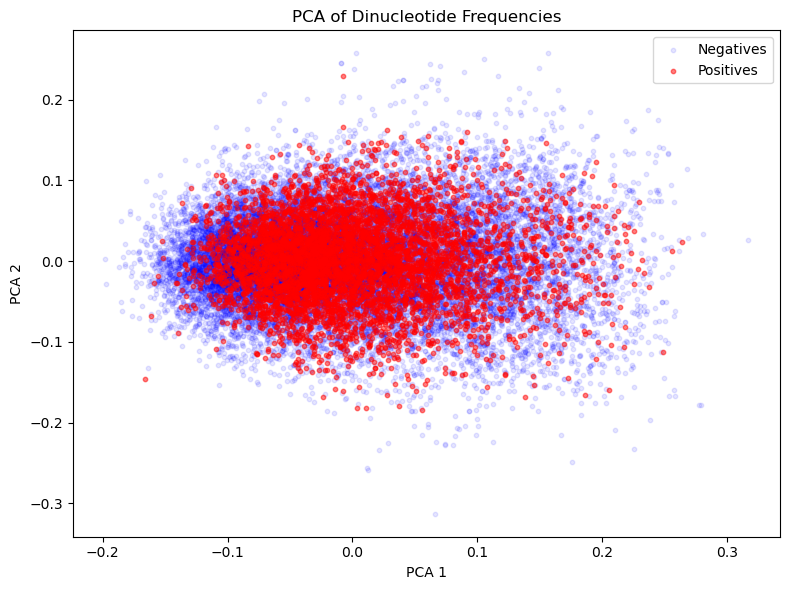

In [42]:
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

# Fit PCA on all data (positives + negatives)
X = pd.concat([pos_vecs, neg_vecs])
y = np.array([1]*n_pos + [0]*n_neg)  # 1 for positives, 0 for negatives

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], color='blue', label='Negatives', alpha=0.1, s=10)
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], color='red', label='Positives', alpha=0.5, s=10)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of Dinucleotide Frequencies')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.manifold import TSNE

# Fit t-SNE on all data (positives + negatives)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[y == 0, 0], X_tsne[y == 0, 1], color='blue', label='Negatives', alpha=0.1, s=10)
plt.scatter(X_tsne[y == 1, 0], X_tsne[y == 1, 1], color='red', label='Positives', alpha=0.5, s=10)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE of Dinucleotide Frequencies')
plt.legend()
plt.tight_layout()
plt.show()

/data/home/natant/anaconda3/envs/Negs/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Hmmm, I don't see a clear seperation.......

In [ ]:
import numpy as np

def greedy_match_negatives_from_indices(dinuc_matrix,
                                        pos_indices,
                                        neg_indices):

    # Number of positives and negatives
    n_pos = len(pos_indices)
    n_neg = len(neg_indices)

    if n_pos == 0:
        raise ValueError("pos_indices is empty; no positives to match.")
    if n_neg < n_pos:
        raise ValueError(
            f"Not enough negatives ({n_neg}) to match {n_pos} positives."
        )

    # Build an array of negative‐vectors keyed in the same order as neg_indices
    neg_vecs = dinuc_matrix.loc[neg_indices]   # shape = (n_neg, 16)

    # We will keep track of which negatives remain available by
    # maintaining a Python list of remaining_neg_indices and a parallel array remaining_neg_vecs.
    remaining_neg_indices = neg_indices.copy()
    remaining_neg_vecs = neg_vecs.copy()  # shape = (n_neg, 16)

    matched_negatives = []  # will end up length n_pos

    for p in tqdm(pos_indices):
        p_vec = dinuc_matrix.loc[p]            # shape = (16,)
        # Compute distance from p_vec to each available negative‐vector
        #   diff shape = (current_pool_size, 16)
        diff = remaining_neg_vecs - p_vec
        dists = np.linalg.norm(diff, axis=1)   # Euclidean, shape = (current_pool_size,)

        # Find argmin among the still‐available negatives
        best_j = np.argmin(dists)
        best_neg_idx = remaining_neg_indices[best_j]

        # Record it and remove from the pool
        matched_negatives.append(best_neg_idx)
        remaining_neg_indices = np.delete(remaining_neg_indices, best_j)
        remaining_neg_vecs = remaining_neg_vecs.drop(remaining_neg_vecs.index[best_j])

    return matched_negatives


In [ ]:
sampled_negatives = np.array(greedy_match_negatives_from_indices(df_dinuc, positives, negatives))

  1%|          | 39/5506 [00:00<00:14, 386.69it/s]

100%|██████████| 5506/5506 [00:11<00:00, 486.19it/s]
